In [1]:
# -*- coding: UTF-8 -*-
#%load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [2]:
from __future__ import division
import tensorflow as tf
from os import path, remove
import numpy as np
import pandas as pd
import csv
from sklearn.model_selection import StratifiedShuffleSplit
from time import time
from matplotlib import pyplot as plt
import seaborn as sns
from mylibs.jupyter_notebook_helper import show_graph, renderStatsList, renderStatsCollection, \
    renderStatsListWithLabels, renderStatsCollectionOfCrossValids
from tensorflow.contrib import rnn
from tensorflow.contrib import learn
import shutil
from tensorflow.contrib.learn.python.learn import learn_runner
from mylibs.tf_helper import getDefaultGPUconfig
from sklearn.metrics import r2_score
from mylibs.py_helper import factors
from fastdtw import fastdtw
from collections import OrderedDict
from scipy.spatial.distance import euclidean
from statsmodels.tsa.stattools import coint
from common import get_or_run_nn
from data_providers.price_history_seq2seq_data_provider import PriceHistorySeq2SeqDataProvider
from skopt.space.space import Integer, Real
from skopt import gp_minimize
from skopt.plots import plot_convergence
import pickle
import inspect
import dill
import sys
#from models.price_history_21_seq2seq_dyn_dec_ins import PriceHistorySeq2SeqDynDecIns
from data_providers.PriceHistoryMobileAttrsCombinator import PriceHistoryMobileAttrsCombinator
from sklearn.neighbors import NearestNeighbors
from datetime import datetime
from data_providers.price_hist_with_relevant_deals import PriceHistWithRelevantDeals
from data_providers.price_history_29_dataset_per_mobile_phone import PriceHistoryDatasetPerMobilePhone
from arima.arima_estimator import ArimaEstimator
import warnings
from collections import OrderedDict
from mylibs.py_helper import cartesian_coord
from arima.arima_cv import ArimaCV

/home/student/anaconda2/envs/dis/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
dtype = tf.float32
seed = 16011984
random_state = np.random.RandomState(seed=seed)
config = getDefaultGPUconfig()
n_jobs = 1
%matplotlib inline

### Step 0 - hyperparams

vocab_size is all the potential words you could have (classification for translation case)
and max sequence length are the SAME thing

decoder RNN hidden units are usually same size as encoder RNN hidden units in translation but for our case it does not seem really to be a relationship there but we can experiment and find out later, not a priority thing right now

In [4]:
input_len = 60
target_len = 30
batch_size = 50
with_EOS = False

In [5]:
csv_in = '../price_history_03_seq_start_suddens_trimmed.csv'

# Actual Run

In [6]:
data_path = '../../../../Dropbox/data'
ph_data_path = data_path + '/price_history'
assert path.isdir(ph_data_path)

In [7]:
npz_full = ph_data_path + '/price_history_per_mobile_phone.npz'

In [8]:
#dataset_gen = PriceHistoryDatasetPerMobilePhone(random_state=random_state)

In [9]:
dic = np.load(npz_full)
dic.keys()[:10]

['9820435',
 '8332719',
 '7357394',
 '9351583',
 '7655259',
 '6253594',
 '8138004',
 '10576161',
 '7408246',
 '7967487']

# Arima

In [10]:
parameters = OrderedDict([
    ('p_auto_regression_order', range(6)), #0-5
    ('d_integration_level', range(3)), #0-2
    ('q_moving_average', range(6)), #0-5
])

In [11]:
cart = cartesian_coord(*parameters.values())
cart.shape

(108, 3)

In [12]:
cur_key = dic.keys()[0]
cur_key

'9820435'

In [13]:
cur_sku = dic[cur_key][()]
cur_sku.keys()

['test', 'train', 'train_dates']

In [14]:
train_mat = cur_sku['train']
train_mat.shape

(31, 90)

In [15]:
target_len

30

In [16]:
inputs = train_mat[:, :-target_len]
inputs.shape

(31, 60)

In [17]:
targets = train_mat[:, -target_len:]
targets.shape

(31, 30)

In [18]:
easy_mode = False

In [19]:
score_dic_filepath = data_path + "/arima/scoredic_easy_mode_{}_{}.npy".format(easy_mode, cur_key)
path.abspath(score_dic_filepath)

'/home/student/Dropbox/data/arima/scoredic_easy_mode_False_9820435.npy'

In [20]:
%%time
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    scoredic = ArimaCV.cross_validate(inputs=inputs, targets=targets, cartesian_combinations=cart,
                                      score_dic_filepath=score_dic_filepath, easy_mode=easy_mode)

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 4.45 ms


In [21]:
#4h 4min 51s / 108 cases => ~= 136 seconds per case !

In [22]:
arr = np.array(list(scoredic.iteritems()))
arr.shape

(108, 2)

In [23]:
#np.isnan()
filtered_arr = arr[ np.logical_not(arr[:, 1] != arr[:, 1]) ]
filtered_arr.shape

(102, 2)

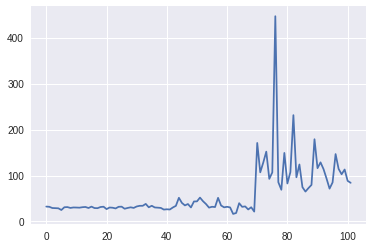

In [24]:
plt.plot(filtered_arr[:, 1])

In [25]:
minarg = np.argmin(filtered_arr[:, 1])
minarg

62

In [26]:
best_params = filtered_arr[minarg, 0]
best_params

(4, 1, 3)

In [27]:
test_mat = cur_sku['test']
test_ins = test_mat[:-target_len]
test_ins.shape

(60,)

In [28]:
test_tars = test_mat[-target_len:]
test_tars.shape

(30,)

In [29]:
test_ins_vals = test_ins.values.reshape(1, -1)
test_ins_vals.shape

(1, 60)

In [30]:
test_tars_vals = test_tars.values.reshape(1, -1)
test_tars_vals.shape

(1, 30)

# Testing with easy mode on

In [31]:
%%time
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    ae = ArimaEstimator(p_auto_regression_order=best_params[0],
                        d_integration_level=best_params[1],
                        q_moving_average=best_params[2],
                        easy_mode=True)
    score = ae.fit(test_ins_vals, test_tars_vals).score(test_ins_vals, test_tars_vals)

CPU times: user 11.7 s, sys: 22.9 s, total: 34.6 s
Wall time: 8.4 s


In [32]:
score

6.567110444670174

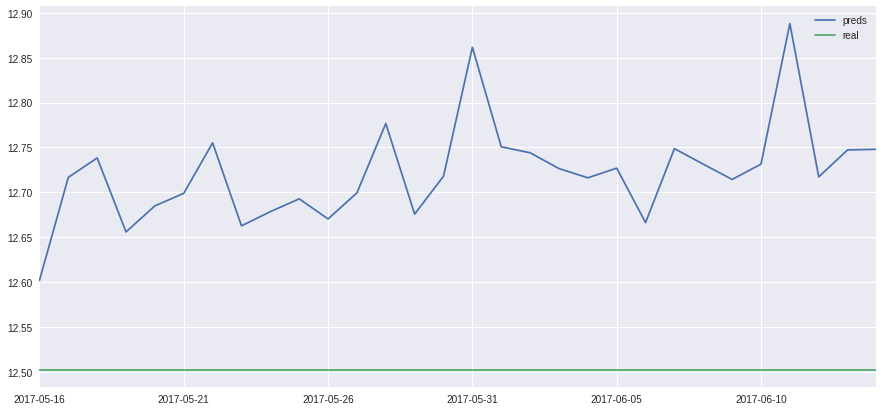

In [33]:
plt.figure(figsize=(15,7))
plt.plot(ae.preds.flatten(), label='preds')
test_tars.plot(label='real')
plt.legend()
plt.show()

# Testing with easy mode off

In [34]:
%%time
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    ae = ArimaEstimator(p_auto_regression_order=best_params[0],
                        d_integration_level=best_params[1],
                        q_moving_average=best_params[2],
                        easy_mode=False)
    score = ae.fit(test_ins_vals, test_tars_vals).score(test_ins_vals, test_tars_vals)

CPU times: user 11.7 s, sys: 22.6 s, total: 34.3 s
Wall time: 8.15 s


In [35]:
score

72.308500086941933

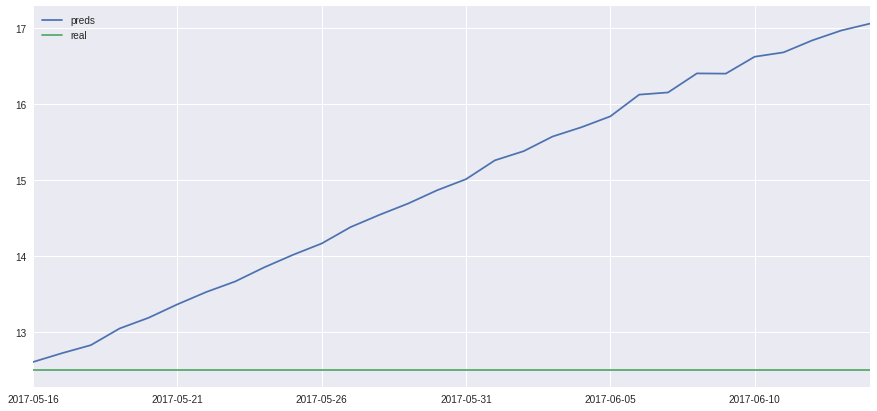

In [36]:
plt.figure(figsize=(15,7))
plt.plot(ae.preds.flatten(), label='preds')
test_tars.plot(label='real')
plt.legend()
plt.show()

#### Conclusion
If you are training in easy mode then what you get at the end is that the model only cares for the previous value in order to do its predictions and this makes it much easier for everybody but in reality we might not have advantage

# Trying

In [37]:
args = np.argsort(filtered_arr[:, 1])
args

array([ 62,  63,  69,   5,  39,  41,  67,  40,  20,  26,  23,   4,  17,
         3,  16,   2,  14,  27,   8,  29,  38,  22,  11,  37,  54,  10,
        21,  42,  48,   9,  36,  61,  59,  28,  34,  68,   6,  12,   7,
        56,  18,  13,  65,  24,   1,  60,  55,  19,  25,  15,   0,  30,
        66,  43,  31,  32,  35,  58,  46,  53,  47,  33,  64,  45,  49,
        50,  52,  57,  44,  51,  86,  78,  94,  87,  85,  88,  80, 101,
        95,  77, 100,  74,  93,  83,  98,  75,  71,  81,  99,  92,  97,
        90,  84,  72,  91,  96,  79,  73,  70,  89,  82,  76])

In [38]:
filtered_arr[args[:10], 0]

array([(4, 1, 3), (4, 1, 4), (5, 1, 4), (0, 0, 5), (0, 1, 3), (0, 1, 5),
       (5, 1, 2), (0, 1, 4), (3, 0, 2), (4, 0, 2)], dtype=object)

72.3085000869


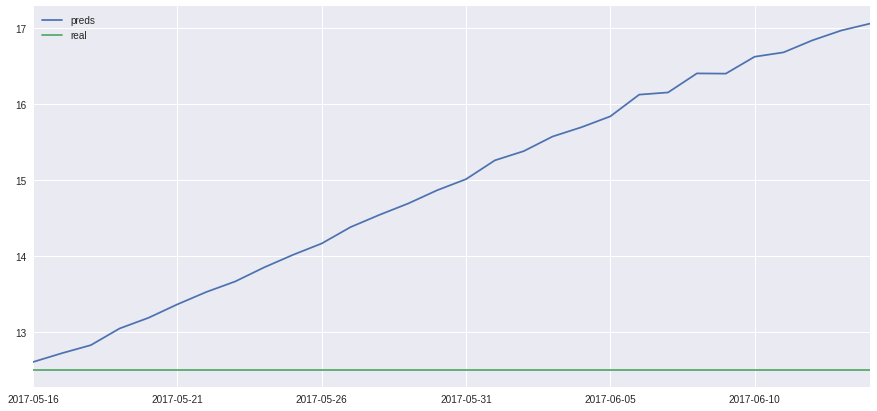

CPU times: user 11.5 s, sys: 23 s, total: 34.6 s
Wall time: 8.14 s


In [39]:
%%time
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    ae = ArimaEstimator(p_auto_regression_order=4,
                        d_integration_level=1,
                        q_moving_average=3,
                        easy_mode=False)
    print ae.fit(test_ins_vals, test_tars_vals).score(test_ins_vals, test_tars_vals)

plt.figure(figsize=(15,7))
plt.plot(ae.preds.flatten(), label='preds')
test_tars.plot(label='real')
plt.legend()
plt.show()

# All tests

In [40]:
from arima.arima_testing import ArimaTesting

In [ ]:
best_params, target_len, npz_full

((4, 1, 3),
 30,
 '../../../../Dropbox/data/price_history/price_history_per_mobile_phone.npz')

In [ ]:
%%time
keys, scores, preds = ArimaTesting.full_testing(best_params=best_params, target_len=target_len,
                                                    npz_full=npz_full)

0 , 9820435
1 , 8332719
2 , 7357394
3 , 9351583
4 , 7655259
5 , 6253594
6 , 8138004
7 , 10576161
8 , 7408246
9 , 7967487
10 , 9130370
11 , 8779166
12 , 7653378
13 , 10536998
14 , 8669008
15 , 9896674
16 , 9941958
17 , 7780575
18 , 10499793
19 , 9259167
20 , 9409718
21 , 9986194
22 , 9898913
23 , 10129132
24 , 9055991
25 , 8515393
26 , 7364333
27 , 8176770
28 , 7507905
29 , 3656048
30 , 10112367
31 , 8695009
32 , 8735993
33 , 10242128
34 , 8414311
35 , 9547257
36 , 7508833
37 , 9426447
38 , 6261140
39 , 7294741
40 , 9674179
41 , 9064268
42 , 9672674


In [52]:
# render graphs here

In [56]:
score_arr = np.array(scores)

In [59]:
np.mean(score_arr[np.logical_not(score_arr != score_arr)])

21.673050084413859